In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# import higherOrderKME
# from higherOrderKME import sigkernel
import Path_Char
from Path_Char.path_characteristic_function import char_func_path
from Path_Char.model import LSTMRegressor, UnitaryLSTMGenerator, UnitaryLSTMRegressor
from Path_Char.utils import AddTime
from torch.utils.data import DataLoader
import ml_collections
from torch.distributions import Bernoulli
import seaborn as sns
import os
import itertools
# import signatory
import torch.nn as nn
from fbm import FBM
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
sns.set()
torch.manual_seed(0)
device = 'cuda'

In [18]:
def FBM_data(num_samples, dim, length, h):
    fbm_paths = []
    for i in range(num_samples*dim):
        f = FBM(n=length, hurst=h, method='daviesharte')
        fbm_paths.append(f.fbm())
    data = torch.FloatTensor(np.array(fbm_paths)).reshape(
        num_samples, dim, length+1).permute(0, 2, 1)
    return data

In [19]:
# Construct fbm path with different Hurst parameter

samples = 10000
steps = 50

bm = FBM_data(samples, dim=3, length=steps, h=0.5)
fbm_h = FBM_data(samples, dim=3, length=steps, h=0.475)

bm_test = FBM_data(samples, dim=3, length=steps, h=0.5)
fbm_h_test = FBM_data(samples, dim=3, length=steps, h=0.475)

fbm_h = fbm_h.to(device)
bm = bm.to(device)
fbm_h_test = fbm_h_test.to(device)
bm_test = bm_test.to(device)

In [20]:
# Construct rank 1 pcf discriminator
input_dim = fbm_h.shape[-1]
num_samples_1 = 8
lie_degree_1 = 8
pcf_level_1 = char_func_path(num_samples=num_samples_1,
                             hidden_size=lie_degree_1,
                             input_dim= input_dim,
                             lie_group = 'unitary',
                             add_time=True,
                             include_initial=False,
                             return_sequence=False).to(device)

In [21]:
batch_size = 1024
# Build the dataset
X_train_dl = DataLoader(bm, batch_size, shuffle=True)
Y_train_dl = DataLoader(fbm_h, batch_size, shuffle=True)

X_test_dl = DataLoader(bm_test, batch_size, shuffle=True)
Y_test_dl = DataLoader(fbm_h_test, batch_size, shuffle=True)

In [22]:
from torch.optim.lr_scheduler import LinearLR
def train_M(pcf_level_2, X_dl, Y_dl, iterations):
#     iterations = 5000
    best_loss = 0.
    losses = []
    char_2_optimizer = torch.optim.Adam(pcf_level_2.parameters(), betas=(0, 0.9), lr=0.02)
#     scheduler = LinearLR(char_2_optimizer, start_factor=1, end_factor=0.1, total_iters=iterations)
    print('start opitmize charateristics function')
    pcf_level_2.train()
    for i in tqdm(range(iterations)):

        X = next(iter(X_dl))
        Y = next(iter(Y_dl))
        char_2_optimizer.zero_grad()
        char_loss = - pcf_level_2.distance_measure(X, Y, Lambda=0)
        losses.append(char_loss)
        if -char_loss > best_loss:
            print("Loss updated: {}".format(-char_loss))
            best_loss = -char_loss
        if i % 100 == 0:
            print("Iteration {} :".format(i), " loss = {}".format(-char_loss))
        char_loss.backward()
#         for param in pcf_level_2.parameters():
#             print("grad:", torch.norm(param.grad))
#             print("param:", torch.norm(param))
        char_2_optimizer.step()
#         scheduler.step()
    return pcf_level_2, losses


def evaluate(pcf_level_2, X_dl, Y_dl):
    pcf_level_2.eval()
    repeats = 100
    MMD_1 = np.zeros((repeats))
    MMD_2 = np.zeros((repeats))
    with torch.no_grad():
        for i in tqdm(range(repeats)):
            exp_dev_X = next(iter(X_dl))
            exp_dev_X_ = next(iter(X_dl))
            exp_dev_Y = next(iter(Y_dl))
            

            MMD_1[i] = pcf_level_2.distance_measure(exp_dev_X, exp_dev_X_, Lambda=0)
            MMD_2[i] = pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)
            
    fig, ax = plt.subplots(1,1,figsize=(15,5))

    ax.hist(MMD_1, bins=25, label='H_0',edgecolor='#E6E6E6')
    ax.hist(MMD_2, bins=25, label='H_A',edgecolor='#E6E6E6')

    ax.legend(loc='upper right', ncol=2, fontsize=22)
    ax.set_xlabel('D_1(X, Y)^2', labelpad=10)
    ax.set_ylabel('Count', labelpad=10)

    plt.tight_layout(pad=3.0)
    # plt.savefig('MMD_binary_tex.pdf',bbox_inches='tight')
    plt.show()
    return MMD_1, MMD_2


def permutation_test(pcf, X, Y, sample_size, num_permutations=500):
        with torch.no_grad():
            pcf.eval()

#             X = self.subsample(X, sample_size).to(self.device)
#             Y = self.subsample(Y, sample_size).to(self.device)

            # print(t1)
            n, m = X.shape[0], Y.shape[0]
            combined = torch.cat([X, Y])
            H0_stats = np.zeros((num_permutations))
            H1_stats = np.zeros((num_permutations))

            for i in tqdm(range(num_permutations)):
                X_sample = subsample(X, sample_size).to(device)
                Y_sample = subsample(Y, sample_size).to(device)
                
                n, m = X_sample.shape[0], Y_sample.shape[0]
                combined = torch.cat([X_sample, Y_sample])
                
                
                idx = torch.randperm(n + m)
                H0_stats[i] = pcf.distance_measure(combined[idx[:n]], combined[idx[n:]],  Lambda=0)
                H1_stats[i] = pcf.distance_measure(X_sample, Y_sample,  Lambda=0)
            Q_a = np.quantile(np.array(H0_stats), q=0.95)
            Q_b = np.quantile(np.array(H1_stats), q=0.05)

            # print(statistics)
            # print(np.array(statistics))
            power = 1 - (Q_a > np.array(H1_stats)).sum() / num_permutations
            type1_error = (Q_b < np.array(H0_stats)).sum() / num_permutations
            
            print_hist(H0_stats, H1_stats)
        return power, type1_error

def subsample(data, sample_size):
    idx = torch.randint(low=0, high=data.shape[0], size=[sample_size])
    return data[idx]

def print_hist(hist_1, hist_2):
    fig, ax = plt.subplots(1,1,figsize=(15,5))

    ax.hist(hist_1, bins=25, label='H_0',edgecolor='#E6E6E6')
    ax.hist(hist_2, bins=25, label='H_A',edgecolor='#E6E6E6')

    ax.legend(loc='upper right', ncol=2, fontsize=22)
    ax.set_xlabel('D_1(X, Y)^2', labelpad=10)
    ax.set_ylabel('Count', labelpad=10)

    plt.tight_layout(pad=3.0)
    # plt.savefig('MMD_binary_tex.pdf',bbox_inches='tight')
    plt.show()

In [23]:
torch.manual_seed(42)
# Train the discriminator
trained_pcf_level_1, losses = train_M(pcf_level_1, X_train_dl, Y_train_dl, 2000)

start opitmize charateristics function


  0%|          | 0/2000 [00:00<?, ?it/s]

Loss updated: 0.015219569206237793
Iteration 0 :  loss = 0.015219569206237793
Loss updated: 0.015780653804540634
Loss updated: 0.016765683889389038
Loss updated: 0.017557144165039062
Loss updated: 0.0175652876496315
Loss updated: 0.018440641462802887
Loss updated: 0.019455021247267723
Loss updated: 0.01978195458650589
Loss updated: 0.01995454728603363
Loss updated: 0.02142326533794403
Iteration 100 :  loss = 0.01945130154490471
Loss updated: 0.022764764726161957
Loss updated: 0.02284570038318634
Loss updated: 0.02307734452188015
Loss updated: 0.023283634334802628
Loss updated: 0.023318244144320488
Loss updated: 0.02339818701148033
Loss updated: 0.023534324020147324
Iteration 200 :  loss = 0.02056768164038658
Loss updated: 0.02459692396223545
Loss updated: 0.025181129574775696
Loss updated: 0.025192655622959137
Loss updated: 0.02554839849472046
Loss updated: 0.02595357410609722
Loss updated: 0.026309367269277573
Iteration 300 :  loss = 0.023260802030563354
Loss updated: 0.02644598484039

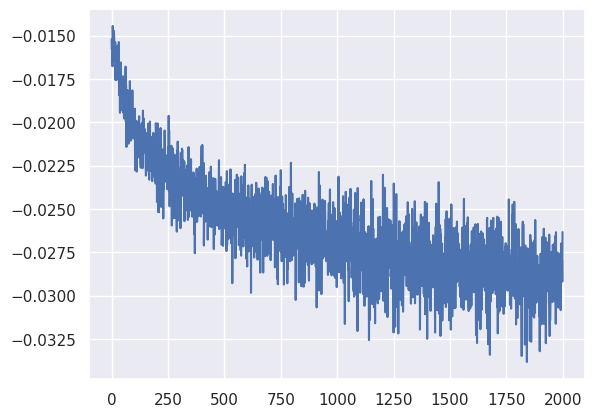

In [24]:
# Loss plot
plt.plot(torch.stack(losses).detach().cpu())

In [25]:
pcf_level_1.unitary_development.projection.A.shape

torch.Size([4, 8, 8, 8])

  0%|          | 0/100 [00:00<?, ?it/s]

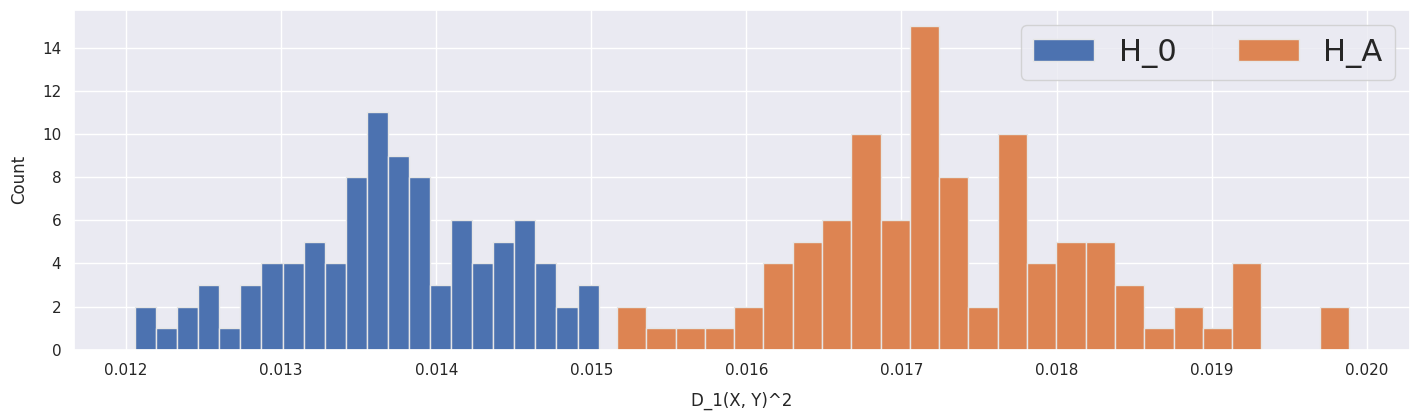

In [26]:
# Test the discriminative power
MMD_1, MMD_2 = evaluate(pcf_level_1, X_test_dl, Y_test_dl)

In [27]:
Q_a = np.quantile(np.array(MMD_1), q=0.95)
Q_b = np.quantile(np.array(MMD_2), q=0.05)

# print(statistics)
# print(np.array(statistics))
power = 1 - (Q_a > np.array(MMD_2)).sum() / 100
type1_error = (Q_b < np.array(MMD_1)).sum() / 100

In [28]:
power

1.0

  0%|          | 0/500 [00:00<?, ?it/s]

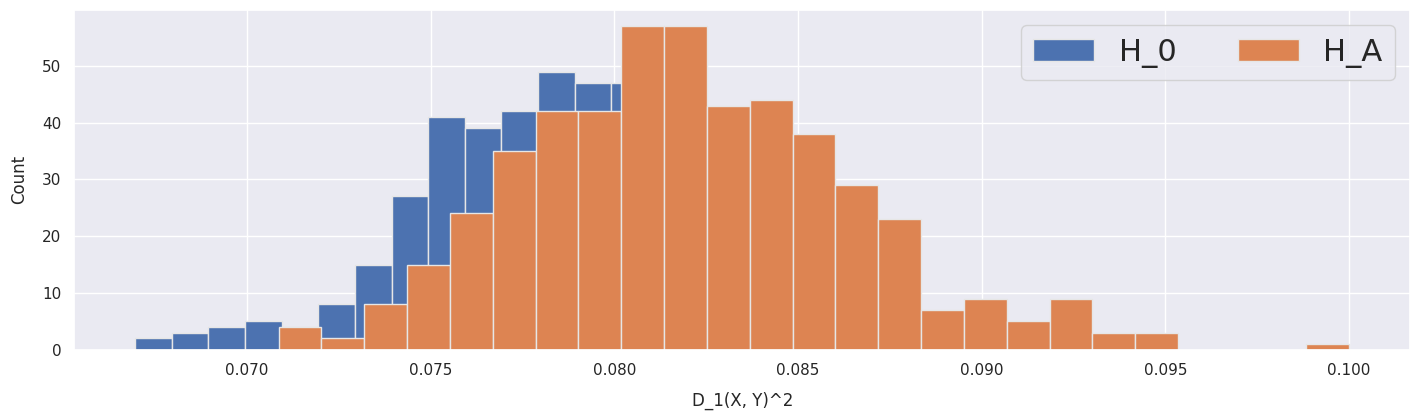

In [31]:
power, type1_error = permutation_test(pcf_level_1, bm_test, fbm_h_test, 200)

In [32]:
power

0.17600000000000005

### Rank 2 PCF

In [6]:
# Regression model parameters
config = {'G_input_dim': 4,
          'G_hidden_dim': 128,
          'G_num_layers': 5,
          'G_output_dim': 5}
config = ml_collections.ConfigDict(config)

In [7]:
lie_degree_1 = 5
num_samples_1 = 1
input_size = 3
add_time = True

pcf_level_1 = char_func_path(num_samples=num_samples_1, 
                              hidden_size=lie_degree_1, 
                              input_dim=input_size, 
                              add_time=add_time, 
                              include_initial = False,
                              return_sequence=False)
pcf_level_1.to(device)

char_func_path(
  (unitary_development): development_layer(
    (projection): projection(
      (param_map): unitary()
    )
  )
)

In [8]:
pcf_level_1.unitary_development.projection.A.shape

torch.Size([4, 1, 5, 5])

In [8]:
# Prepare dataset for regression
batch_size = 512
with torch.no_grad():
    dev_X = pcf_level_1.unitary_development(AddTime(bm).to(device)).repeat([1, steps+1, 1, 1])
    dev_Y = pcf_level_1.unitary_development(AddTime(fbm_h).to(device)).repeat([1, steps+1, 1, 1])
    
# train_X_dl = DataLoader(AddTime(bm), batch_size, shuffle=True)
# train_X_dev_dl = DataLoader(dev_X, batch_size, shuffle=True)

# train_Y_dl = DataLoader(AddTime(fbm_h), batch_size, shuffle=True)
# train_Y_dev_dl = DataLoader(dev_Y, batch_size, shuffle=True)

In [9]:
joint_train_X_dl = DataLoader(AddTime(torch.cat([bm, fbm_h])), batch_size, shuffle=True)
joint_train_X_dev_dl = DataLoader(torch.cat([dev_X, dev_Y]), batch_size, shuffle=True)

In [10]:
test_X_dl = DataLoader(AddTime(bm_test), batch_size, shuffle=True)
test_Y_dl = DataLoader(AddTime(fbm_h_test), batch_size, shuffle=True)

In [11]:
regressor_for_X = LSTMRegressor(
        input_dim=config.G_input_dim,
        hidden_dim=config.G_hidden_dim,
        output_dim=config.G_output_dim,
        n_layers=config.G_num_layers
    )
regressor_for_X.to(device)

train_X_dl = DataLoader(AddTime(bm), batch_size, shuffle=True)
train_X_dev_dl = DataLoader(dev_X, batch_size, shuffle=True)

regressor_for_Y = LSTMRegressor(
        input_dim=config.G_input_dim,
        hidden_dim=config.G_hidden_dim,
        output_dim=config.G_output_dim,
        n_layers=config.G_num_layers
    )
regressor_for_Y.to(device)

train_Y_dl = DataLoader(AddTime(fbm_h), batch_size, shuffle=True)
train_Y_dev_dl = DataLoader(dev_Y, batch_size, shuffle=True)

LSTMRegressor(
  (rnn): LSTM(4, 128, num_layers=5, batch_first=True)
  (linear): Linear(in_features=128, out_features=50, bias=False)
  (activation): Tanh()
)

In [12]:
def train_regressor(regressor, iterations, X_dl, Y_dl):
    best_loss = 10000.
    loss = []
    regressor_optimizer = torch.optim.Adam(regressor.parameters(), betas=(0, 0.9), lr=0.001)
    regressor.train()
    for i in tqdm(range(iterations)):
        regressor_optimizer.zero_grad()
        batch_X = next(iter(X_dl))
        batch_X_dev = next(iter(Y_dl))
#         print(batch_X.shape, batch_X_dev.shape)
        reg_dev = regressor(batch_X, device)
#         print(reg_dev.shape, batch_X_dev.shape)
        
        regressor_loss = torch.norm(reg_dev - batch_X_dev, dim = (2,3)).sum(1).mean()
        loss.append(regressor_loss)
        if regressor_loss < best_loss:
            print("Loss updated: {}".format(regressor_loss), " at iteration {}".format(i))
#             with torch.no_grad():
#                 print(torch.norm(reg_dev - batch_X_dev, dim = [2,3]).mean(0))
            best_loss = regressor_loss
            trained_regressor = regressor

        regressor_loss.backward()
        regressor_optimizer.step()
    
    return trained_regressor, loss

In [13]:
trained_regressor_X, loss_X = train_regressor(regressor_for_X, 2000, train_X_dl, train_X_dev_dl)
trained_regressor_Y, loss_Y = train_regressor(regressor_for_Y, 2000, train_X_dl, train_X_dev_dl)

  0%|          | 0/2000 [00:00<?, ?it/s]

Loss updated: 121.75407409667969  at iteration 0
Loss updated: 116.63626098632812  at iteration 1
Loss updated: 115.13357543945312  at iteration 2
Loss updated: 114.22623443603516  at iteration 3
Loss updated: 114.15397644042969  at iteration 4
Loss updated: 113.9321060180664  at iteration 6
Loss updated: 113.4575424194336  at iteration 7
Loss updated: 113.22064208984375  at iteration 9
Loss updated: 112.75040435791016  at iteration 10
Loss updated: 112.7451400756836  at iteration 13
Loss updated: 112.56062316894531  at iteration 16
Loss updated: 112.45891571044922  at iteration 24
Loss updated: 112.38392639160156  at iteration 34
Loss updated: 112.29911804199219  at iteration 51
Loss updated: 112.24385833740234  at iteration 54
Loss updated: 112.1541976928711  at iteration 55
Loss updated: 112.0571060180664  at iteration 118
Loss updated: 111.98886108398438  at iteration 131
Loss updated: 111.94779205322266  at iteration 287
Loss updated: 111.90414428710938  at iteration 542
Loss upda

  0%|          | 0/2000 [00:00<?, ?it/s]

Loss updated: 120.58778381347656  at iteration 0
Loss updated: 116.16133117675781  at iteration 1
Loss updated: 114.7709732055664  at iteration 2
Loss updated: 114.14734649658203  at iteration 3
Loss updated: 114.00375366210938  at iteration 4
Loss updated: 113.68501281738281  at iteration 5
Loss updated: 113.28486633300781  at iteration 7
Loss updated: 112.80236053466797  at iteration 10
Loss updated: 112.75978088378906  at iteration 11
Loss updated: 112.65592193603516  at iteration 18
Loss updated: 112.60746765136719  at iteration 20
Loss updated: 112.58494567871094  at iteration 21
Loss updated: 112.5383071899414  at iteration 26
Loss updated: 112.42298889160156  at iteration 29
Loss updated: 112.42137145996094  at iteration 50
Loss updated: 112.38948822021484  at iteration 51
Loss updated: 112.37030029296875  at iteration 53
Loss updated: 112.27806091308594  at iteration 67
Loss updated: 112.18170928955078  at iteration 78
Loss updated: 112.17959594726562  at iteration 107
Loss upd

In [22]:
class expected_dev():

    def __init__(self, regressor_X, regressor_Y, lie_degree_1, lie_degree_2, num_samples_2, add_time=True, device='cuda'):
        super(expected_dev, self).__init__()
        """ Generator base class. All generators should be children of this class. """
        self.device = device
        self.regressor_X = regressor_X
        self.regressor_Y = regressor_Y
        self.regressor_X.to(device)
        self.regressor_Y.to(device)

        self.lie_degree_1 = lie_degree_1
        self.add_time = add_time
        self.num_samples_2 = num_samples_2
        self.lie_degree_2 = lie_degree_2
        self.pcf_level_2 = char_func_path(num_samples=self.num_samples_2,
                                          hidden_size=self.lie_degree_2,
                                          input_dim=2 * self.lie_degree_1 ** 2,
                                          add_time=add_time,
                                          include_initial=False,
                                          return_sequence=False)
        self.pcf_level_2.to(device)



    def train_M(self, X_dl, Y_dl, iterations):
        best_loss = 0.

        char_2_optimizer = torch.optim.Adam(self.pcf_level_2.parameters(), betas=(0, 0.9), lr=0.002)
        losses = []
        print('start opitmize charateristics function')
        self.regressor_X.eval()
        self.regressor_Y.eval()
        self.pcf_level_2.train()
        for i in tqdm(range(iterations)):

            X = next(iter(X_dl))
            Y = next(iter(Y_dl))
            with torch.no_grad():
                exp_dev_X = self.regressor_X(X, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                exp_dev_Y = self.regressor_Y(Y, self.device).reshape([-1, Y.shape[1], self.lie_degree_1 ** 2])

                exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag], -1)
                exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag], -1)

            char_2_optimizer.zero_grad()
            char_loss = - self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)
            losses.append(char_loss.item())
            if -char_loss > best_loss:
                print("Loss updated: {}".format(-char_loss))
                best_loss = -char_loss
            if i % 100 == 0:
                print("Iteration {} :".format(i), " loss = {}".format(-char_loss))
            char_loss.backward()
            char_2_optimizer.step()
        
        return losses

    def evaluate(self, X_dl, Y_dl):
        self.pcf_level_2.eval()
        self.regressor_X.eval()
        self.regressor_Y.eval()
        repeats = 100
        MMD_1 = np.zeros((repeats))
        MMD_2 = np.zeros((repeats))
        with torch.no_grad():
            for i in tqdm(range(repeats)):
                X = next(iter(X_dl))
                Y = next(iter(Y_dl))
                X_ = next(iter(X_dl))
                exp_dev_X = self.regressor_X(X, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                exp_dev_X_ = self.regressor_X(X_, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                exp_dev_Y = self.regressor_Y(Y, self.device).reshape([-1, Y.shape[1], self.lie_degree_1 ** 2])

                exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag], -1)
                exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag], -1)
                exp_dev_X_ = torch.cat([exp_dev_X_.real, exp_dev_X_.imag], -1)

                MMD_1[i] = self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_X_, Lambda=0)
                MMD_2[i] = self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)
        return MMD_1, MMD_2

In [23]:
expected_devx = expected_dev(regressor_X = regressor_for_X, regressor_Y = regressor_for_Y, 
                             lie_degree_1 = 5, lie_degree_2 = 5, num_samples_2 = 10)

In [24]:
losses = expected_devx.train_M(train_X_dl, train_X_dl, 200)

start opitmize charateristics function


  0%|          | 0/200 [00:00<?, ?it/s]

Loss updated: 0.0022376698907464743
Iteration 0 :  loss = 0.0022376698907464743
Loss updated: 0.0022956300526857376
Loss updated: 0.0023547231685370207
Loss updated: 0.002421872690320015
Loss updated: 0.0024815481156110764
Loss updated: 0.0025462894700467587
Loss updated: 0.0026164271403104067
Loss updated: 0.002679932164028287
Loss updated: 0.0027530088555067778
Loss updated: 0.0028204445261508226
Loss updated: 0.002896134974434972
Loss updated: 0.00297248805873096
Loss updated: 0.00304789817892015
Loss updated: 0.0031207501888275146
Loss updated: 0.003200536360964179
Loss updated: 0.003282291581854224
Loss updated: 0.0033600598108023405
Loss updated: 0.0034419891890138388
Loss updated: 0.0035292550455778837
Loss updated: 0.0036134866531938314
Loss updated: 0.0036987054627388716
Loss updated: 0.0037901257164776325
Loss updated: 0.0038749754894524813
Loss updated: 0.0039698234759271145
Loss updated: 0.004063458647578955
Loss updated: 0.004151548258960247
Loss updated: 0.004254562780261

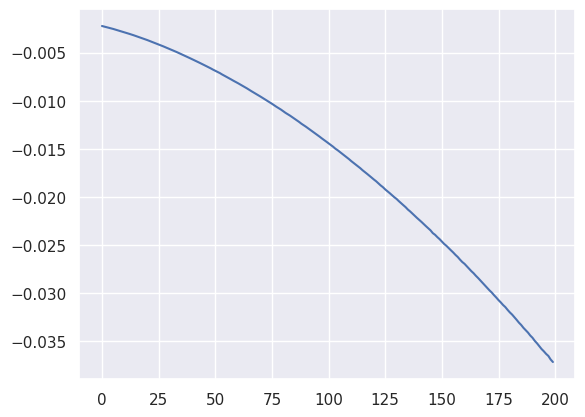

In [25]:
plt.plot(losses)

In [26]:
MMD_1, MMD_2 = expected_devx.evaluate(test_X_dl, test_Y_dl)

NameError: name 'test_X_dl' is not defined

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

ax.hist(MMD_1, bins=25, label='H_0',edgecolor='#E6E6E6')
ax.hist(MMD_2, bins=25, label='H_A',edgecolor='#E6E6E6')

ax.legend(loc='upper right', ncol=2, fontsize=22)
ax.set_xlabel('D_1(X, Y)^2', labelpad=10)
ax.set_ylabel('Count', labelpad=10)

plt.tight_layout(pad=3.0)
# plt.savefig('MMD_binary_tex.pdf',bbox_inches='tight')
plt.show()

In [29]:
MMD_2.shape

(100,)

In [30]:
MMD_1.shape

(100,)